# Face

Install necessary libraries

In [1]:
#pip install --upgrade --trusted-host pypi.org --trusted-host files.pythonhosted.org azure-cognitiveservices-vision-face

Import necessary libraries

In [1]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
# To install this module, run:
# python -m pip install Pillow
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person

Define subscription endpoint and key

In [2]:
KEY = "PLEASE_ENTER_YOUR_OWN_KEY"
ENDPOINT = "https://PLEASE_ENTER_YOUR_OWN_ENDPOINT_NAME.cognitiveservices.azure.com/"

Define the authentication client

In [3]:
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

Detect faces in an image

In [4]:
# Detect a face in an image that contains a single face
single_face_image_url = 'https://raw.githubusercontent.com/Microsoft/Cognitive-Face-Windows/master/Data/detection1.jpg'
single_image_name = os.path.basename(single_face_image_url)
# We use detection model 3 to get better performance.
detected_faces = face_client.face.detect_with_url(url=single_face_image_url, detection_model='detection_03')
if not detected_faces:
    raise Exception('No face detected from image {}'.format(single_image_name))

# Display the detected face ID in the first single-face image.
# Face IDs are used for comparison to faces (their IDs) detected in other images.
print('Detected face ID from', single_image_name, ':')
for face in detected_faces: print (face.face_id)
print()

# Save this ID for use in Find Similar
first_image_face_ID = detected_faces[0].face_id

Detected face ID from detection1.jpg :
4c4f35a5-2d1f-48df-9eb1-e3192eb5b8e2



In [5]:
# Detect a face in an image that contains a single face
single_face_image_url = 'https://raw.githubusercontent.com/Microsoft/Cognitive-Face-Windows/master/Data/detection1.jpg'
single_image_name = os.path.basename(single_face_image_url)
# We use detection model 3 to get better performance.
detected_faces = face_client.face.detect_with_url(url=single_face_image_url, detection_model='detection_03')
if not detected_faces:
    raise Exception('No face detected from image {}'.format(single_image_name))

# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))


# Download the image from the url
response = requests.get(single_face_image_url)
img = Image.open(BytesIO(response.content))

# For each face returned use the face rectangle and draw a red box.
print('Drawing rectangle around face... see popup for results.')
draw = ImageDraw.Draw(img)
for face in detected_faces:
    draw.rectangle(getRectangle(face), outline='red')
    
print(face)

# Display the image in the users default image browser.
img.show()

Drawing rectangle around face... see popup for results.
{'additional_properties': {}, 'face_id': '5d97fda9-1c16-4f7b-8e6c-8736734fdad3', 'recognition_model': None, 'face_rectangle': <azure.cognitiveservices.vision.face.models._models_py3.FaceRectangle object at 0x00000203BF9D8310>, 'face_landmarks': None, 'face_attributes': None}


Find similar faces

In [6]:
# Detect the faces in an image that contains multiple faces
# Each detected face gets assigned a new ID
multi_face_image_url = "https://images.gawker.com/18lreofd702i4jpg/c_scale,fl_progressive,q_80,w_800.jpg"
multi_image_name = os.path.basename(multi_face_image_url)
# We use detection model 3 to get better performance.
detected_faces2 = face_client.face.detect_with_url(url=multi_face_image_url, detection_model='detection_03')

In [7]:
# Search through faces detected in group image for the single face from first image.
# First, create a list of the face IDs found in the second image.
second_image_face_IDs = list(map(lambda x: x.face_id, detected_faces2))
# Next, find similar face IDs like the one detected in the first image.
similar_faces = face_client.face.find_similar(face_id=first_image_face_ID, face_ids=second_image_face_IDs)
if not similar_faces:
    print('No similar faces found in', multi_image_name, '.')
# Print the details of the similar faces detected
else:
    print('Similar faces found in', multi_image_name + ':')
    for face in similar_faces:
        first_image_face_ID = face.face_id
        # The similar face IDs of the single face image and the group image do not need to match, 
        # they are only used for identification purposes in each image.
        # The similar faces are matched using the Cognitive Services algorithm in find_similar().
        face_info = next(x for x in detected_faces2 if x.face_id == first_image_face_ID)
        if face_info:
            print('  Face ID: ', first_image_face_ID)
            print('  Face rectangle:')
            print('    Left: ', str(face_info.face_rectangle.left))
            print('    Top: ', str(face_info.face_rectangle.top))
            print('    Width: ', str(face_info.face_rectangle.width))
            print('    Height: ', str(face_info.face_rectangle.height))

No similar faces found in c_scale,fl_progressive,q_80,w_800.jpg .


Use Face Service via Rest API

In [8]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import patches
from io import BytesIO
import os

In [11]:
image_path = os.path.join('./image/sample2.jpg')
image_data = open(image_path, 'rb')
subscription_key = KEY
face_api_url = "https://southeastasia.api.cognitive.microsoft.com/face/v1.0/detect"
headers = {'Content-Type': 'application/octet-stream',
'Ocp-Apim-Subscription-Key': subscription_key}
params = {
'returnFaceId': 'true',
'returnFaceLandmarks': 'true',
'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion'
}
response = requests.post(face_api_url, params=params, headers=headers, data=image_data)
response.raise_for_status()
faces = response.json()
print(faces)

[{'faceId': '0c6f3999-7cfd-475c-866a-94147275a4e8', 'faceRectangle': {'top': 124, 'left': 459, 'width': 227, 'height': 227}, 'faceLandmarks': {'pupilLeft': {'x': 504.4, 'y': 202.8}, 'pupilRight': {'x': 607.7, 'y': 175.9}, 'noseTip': {'x': 598.5, 'y': 250.9}, 'mouthLeft': {'x': 527.7, 'y': 298.9}, 'mouthRight': {'x': 626.4, 'y': 271.5}, 'eyebrowLeftOuter': {'x': 452.3, 'y': 191.0}, 'eyebrowLeftInner': {'x': 531.4, 'y': 180.2}, 'eyeLeftOuter': {'x': 487.6, 'y': 207.9}, 'eyeLeftTop': {'x': 506.7, 'y': 196.6}, 'eyeLeftBottom': {'x': 506.8, 'y': 212.9}, 'eyeLeftInner': {'x': 526.5, 'y': 204.3}, 'eyebrowRightInner': {'x': 583.7, 'y': 167.6}, 'eyebrowRightOuter': {'x': 635.8, 'y': 141.4}, 'eyeRightInner': {'x': 592.0, 'y': 185.0}, 'eyeRightTop': {'x': 607.3, 'y': 170.1}, 'eyeRightBottom': {'x': 612.2, 'y': 183.4}, 'eyeRightOuter': {'x': 626.6, 'y': 171.7}, 'noseRootLeft': {'x': 549.7, 'y': 201.0}, 'noseRootRight': {'x': 581.7, 'y': 192.9}, 'noseLeftAlarTop': {'x': 557.5, 'y': 241.1}, 'noseRig

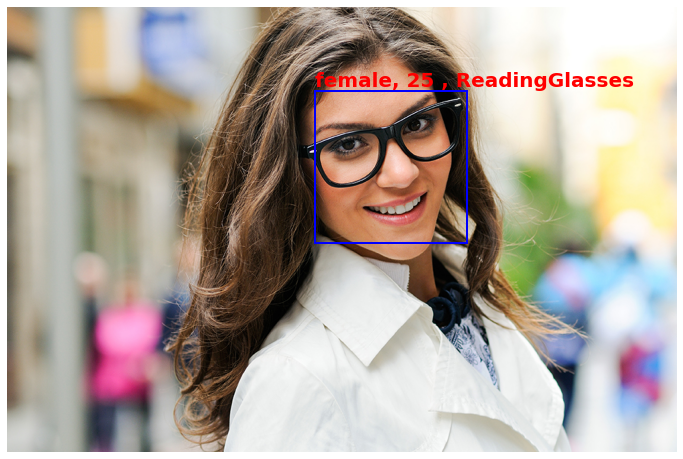

In [12]:
image_orig = open(image_path, 'rb').read()
image = Image.open(BytesIO(image_orig))
plt.figure(figsize=(12, 12))
ax = plt.imshow(image, alpha=1)
for face in faces:
    fr = face['faceRectangle']
    fa = face['faceAttributes']
    origin = (fr['left'], fr['top'])
    p = patches.Rectangle(
    origin, fr['width'], fr['height'], fill=False, linewidth=2, color='b')
    plt.text(origin[0], origin[1], '%s, %d , %s' % (fa['gender'], fa['age'], fa['glasses']),
    fontsize=20, color='r', weight='bold', va='bottom')
    ax.axes.add_patch(p)
    _ = plt.axis('off')
plt.show()

In [9]:
image_path = os.path.join('./image/sample1.jpg')
image_data = open(image_path, 'rb')
subscription_key = KEY
face_api_url = "https://southeastasia.api.cognitive.microsoft.com/face/v1.0/detect"
headers = {'Content-Type': 'application/octet-stream',
'Ocp-Apim-Subscription-Key': subscription_key}
params = {
'returnFaceId': 'true',
'returnFaceLandmarks': 'true',
'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion'
}
response = requests.post(face_api_url, params=params, headers=headers, data=image_data)
response.raise_for_status()
faces = response.json()
print(faces)

[{'faceId': '87ae4f16-47e5-4c2d-86fc-a77ed6280786', 'faceRectangle': {'top': 152, 'left': 327, 'width': 62, 'height': 62}, 'faceLandmarks': {'pupilLeft': {'x': 348.0, 'y': 166.3}, 'pupilRight': {'x': 373.5, 'y': 170.8}, 'noseTip': {'x': 354.5, 'y': 186.7}, 'mouthLeft': {'x': 345.1, 'y': 197.5}, 'mouthRight': {'x': 367.5, 'y': 199.9}, 'eyebrowLeftOuter': {'x': 336.5, 'y': 158.8}, 'eyebrowLeftInner': {'x': 352.2, 'y': 162.6}, 'eyeLeftOuter': {'x': 342.9, 'y': 165.4}, 'eyeLeftTop': {'x': 347.1, 'y': 164.1}, 'eyeLeftBottom': {'x': 345.7, 'y': 168.7}, 'eyeLeftInner': {'x': 350.2, 'y': 167.9}, 'eyebrowRightInner': {'x': 363.6, 'y': 164.7}, 'eyebrowRightOuter': {'x': 386.8, 'y': 166.9}, 'eyeRightInner': {'x': 367.6, 'y': 171.0}, 'eyeRightTop': {'x': 373.1, 'y': 168.4}, 'eyeRightBottom': {'x': 372.2, 'y': 173.4}, 'eyeRightOuter': {'x': 376.9, 'y': 171.4}, 'noseRootLeft': {'x': 353.6, 'y': 169.9}, 'noseRootRight': {'x': 361.8, 'y': 171.3}, 'noseLeftAlarTop': {'x': 349.6, 'y': 181.3}, 'noseRight

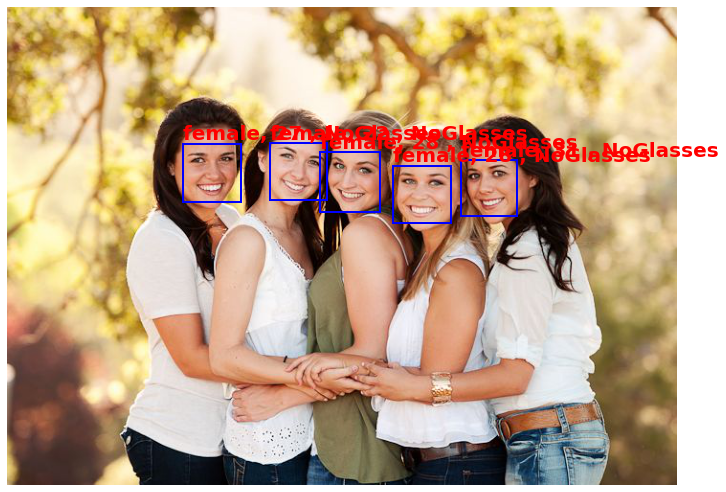

In [10]:
image_orig = open(image_path, 'rb').read()
image = Image.open(BytesIO(image_orig))
plt.figure(figsize=(12, 12))
ax = plt.imshow(image, alpha=1)
for face in faces:
    fr = face['faceRectangle']
    fa = face['faceAttributes']
    origin = (fr['left'], fr['top'])
    p = patches.Rectangle(
    origin, fr['width'], fr['height'], fill=False, linewidth=2, color='b')
    plt.text(origin[0], origin[1], '%s, %d , %s' % (fa['gender'], fa['age'], fa['glasses']),
    fontsize=20, color='r', weight='bold', va='bottom')
    ax.axes.add_patch(p)
    _ = plt.axis('off')
plt.show()